In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline
sns.set_style('whitegrid')

In [33]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [34]:
loans = select('SELECT * FROM LOAN_FINAL')
loans = loans.drop('index',axis=1)

In [35]:
# separating the data into the first general problem at hand: "Completed Loans" 

loans = loans[(loans['loan_status']=='Charged Off') | (loans['loan_status']=='Fully Paid')].copy()
features = loans.drop('loan_status',axis=1).copy()
targets = loans['loan_status'].copy()

In [36]:
# split up features into numerical and non-numerical values

numerical = []
strings = []

for i in range(len(loans.dtypes)):
    if (loans.dtypes[i] == 'int64') or (loans.dtypes[i] == 'float64'):
        numerical = numerical + [loans.dtypes.index[i]]
        
    if (loans.dtypes[i] == 'O') and (loans.dtypes.index[i]!='loan_status'):
        strings = strings + [loans.dtypes.index[i]]

In [37]:
numerical_all = list(numerical)

In [38]:
# contain NaN values need to figure out how to translate the meaning implied by NaN in these columns
# member_id has no predictive value
# removing features containing values which may not be known at time of loan origination (otherwise problem is trivial)
# last three are unnecessary from this problem's standpoint

numerical_all.remove('mths_since_last_delinq')
numerical_all.remove('mths_since_last_major_derog')
numerical_all.remove('member_id')

numerical.remove('mths_since_last_delinq')
numerical.remove('mths_since_last_major_derog')
numerical.remove('member_id')
numerical.remove('delinq_2yrs')
numerical.remove('inq_last_6mths')
numerical.remove('out_prncp')
numerical.remove('out_prncp_inv')
numerical.remove('total_pymnt')
numerical.remove('total_pymnt_inv')
numerical.remove('total_rec_prncp')
numerical.remove('total_rec_int')
numerical.remove('total_rec_late_fee')
numerical.remove('recoveries')
numerical.remove('collection_recovery_fee')
numerical.remove('last_pymnt_amnt')
numerical.remove('collections_12_mths_ex_med')
numerical.remove('tot_coll_amt')
numerical.remove('mths_since_issue')
numerical.remove('mths_left')
numerical.remove('%_term_completed')

In [39]:
print(numerical)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'policy_code', 'acc_now_delinq']


In [40]:
outputmap = {'Charged Off':0,'Fully Paid':1}
targets = targets.apply(lambda x: outputmap[x])

In [41]:
# performs ridiculously well when using all features. need to strip away those that give obvious
# 'hints' to our model about whether the loan will be charged off. (e.g. recoveries, collection recovery fee, etc..)
# otherwise the problem is fairly trivial...we no longer consider this case

# use random_state to ensure same data is used in training/test

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

features_train, features_test, targets_train, targets_test = \
    train_test_split(features[numerical_all],targets,random_state=10,test_size=0.2)

lr_all = LogisticRegression()
lr_all.fit(features_train[numerical_all],targets_train)
accuracy_score(lr_all.predict(features_test[numerical_all]),targets_test)
accuracy_score(lr_all.predict(features_test[numerical_all]),targets_test)

0.99773755656108598

In [42]:
# baseline score using limited features--only those which could be known at time of loan origination
# this problem is less trivial

features_train, features_test, targets_train, targets_test = \
    train_test_split(features[numerical],targets,random_state=10,test_size=0.2)

lr = LogisticRegression()
lr.fit(features_train[numerical],targets_train)
accuracy_score(lr.predict(features_test[numerical]),targets_test)

0.82104866237993168

In [43]:
# precision on the negative cases is fairly bad on both the training and test sets
# recall is very good on the positive cases on both the training and test sets

# seems the model is very good at correctly predicting positive cases, but is excessively likely to predict inputs as positive
# (this is evident by the relatively lower precision)

from sklearn.metrics import classification_report

print('TRAIN'+classification_report(targets_train,lr.predict(features_train[numerical])))
print('TEST'+classification_report(targets_test,lr.predict(features_test[numerical])))

TRAIN             precision    recall  f1-score   support

          0       0.33      0.00      0.00     35601
          1       0.82      1.00      0.90    165949

avg / total       0.74      0.82      0.74    201550

TEST             precision    recall  f1-score   support

          0       0.35      0.00      0.00      9002
          1       0.82      1.00      0.90     41386

avg / total       0.74      0.82      0.74     50388



In [64]:
# the true negative rate is extremely low. however, the model's precision on negative cases is a lot higher (33%)
# it seems the model rarely outputs negative cases..and when it does, it's still only correct a third of the time

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(targets_train,lr.predict(features_train[numerical])).ravel()
TNR = tn/len(targets_train[targets_train==0])
TNR

0.0015729895227662143

In [ ]:
## vv all in training set below

In [78]:
# the model predicts 201k cases as negative, of which 166k were correct. thus precision is ~82% on positive cases

print(tp)
print(sum(lr.predict(features_train[numerical])))

165834
201379


In [90]:
# the model "detects" (recalls) almost 100% of the positive cases

print(tp)
print(len(targets_train[targets_train==1]))

165834
165949


In [76]:
# the model predicts 171 cases as negative, of which 56 were correct. thus precision is ~33% on negative cases

print(tn)
print(sum(((lr.predict(features_train[numerical])-1)*-1)))

56
171


In [92]:
# the model "detects" (recalls) close to 0% of the negative cases

print(tn)
print(len(targets_train[targets_train==0]))

56
35601


In [65]:
# conclusion: the model appears to perform well because there are an excessive number of positive cases in the data set.
# the model outputs positive predictions often and does it well, but misses much of the negative cases

Text(0.5,0,'dti')

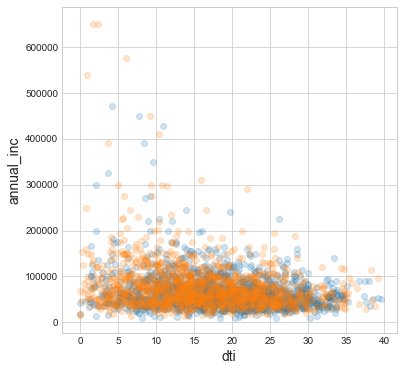

In [44]:
# no two features alone seem to give reliable predictive utility.. orange/blue points are always intermeshed

features = ['dti','annual_inc']

charged_off_sample = loans[loans.loan_status=='Charged Off'][features].sample(1500)
fully_paid_sample = loans[loans.loan_status=='Fully Paid'][features].sample(1500)

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(charged_off_sample[features[0]],charged_off_sample[features[1]],alpha=0.2)
ax.scatter(fully_paid_sample[features[0]],fully_paid_sample[features[1]],alpha=0.2)
ax.set_ylabel(features[1],fontsize=14)
ax.set_xlabel(features[0],fontsize=14)